In [4]:
from scipy.stats import binom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager

In [5]:
popcitiesframe = pd.read_csv("cities_detailed.csv")
allcitiesframe = pd.read_csv(
    "all_cities_densities_no_states.csv",
    dtype={'Population' : 'float32',
           'Density per square mile of land area - Population' : 'float32'})

In [6]:
resident_A = popcitiesframe[['City', 'People in A Resident']]
daytime_A = popcitiesframe[['City', 'People in A Daytime']]
popcities = resident_A['City'].values
allcitiesdens = allcitiesframe[[
    'State',
    'Geographic area', 
    'Population', 
    'Density per square mile of land area - Population'
]]


In [7]:
def rreplace(s, old, new, occurrence):
    li = s.rsplit(old, occurrence)
    return new.join(li)

In [8]:
def myround(x, base=5):
    return int(base * np.floor(float(x)/base))

In [9]:
def getcmfs(numpens, p, resframe, dayframe):
    if resframe.shape[0] != dayframe.shape[0]:
        print "res and day have unequal lengths"
        return
    
    respops = resframe['People in A Resident'].values
    daypops = dayframe['People in A Daytime'].values
    
    results = pd.DataFrame(index=range(1, numpens))
    
    for i in range(len(respops)):
        cityvals = []
        for j in range(1, numpens):
            cityvals.append(1 - (binom.cdf(j, np.floor(respops[i]), p) * (2. / 3.) + 
                                 binom.cdf(j, np.floor(daypops[i]), p) * (1. / 3.)))
            
        results[popcities[i]] = cityvals
    
    return results

In [10]:
def plotcmfs(results, percents, city, lloc='lower left', save=False):
    plt.clf()
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    ls = ['-', '--', ':', '-.']
    
    mx = next(x[0] for x in enumerate(results[percents[-1]][city].values) if x[1] < 0.05)
    mx = myround(mx, 100)
    
    if mx < 100:
        mx = 60
    
    x = range(1, mx + 1)
    for i, perc in enumerate(percents):
        plt.plot(x,
                 results[perc - 1][city].values[:mx], 
                 label=r'%d\%%' % (perc * 10),
                 ls=ls[i % len(ls)])

    plt.legend(loc=lloc)
    plt.title('Nearby Autoinjectors in %s' % rreplace(city, 'city', '', 1).strip())
    plt.xlabel(r'$k$ (Number of Autoinjectors)')
    plt.ylabel(r'$P(N \geq k)$')
    
    if save:
        plt.savefig('figs/%s-cmfs.png' % rreplace(city, 'city', '', 1).strip(), dpi=1000)
    else:
        plt.show()

In [11]:
def getallpercents():
    numpens = 500
    pbase = 6750000. / 321418820.
    results = []
    for i in range(1, 11):
        results.append(getcmfs(numpens, pbase * i / 10., resident_A, daytime_A))
    return results

In [268]:
results = getallpercents()

In [278]:
for city in popcities:
    if city == 'Tucson city' or city == r'Louisville/Jefferson County metro government (balance)':
        continue
    plotcmfs(results, range(1, 10, 2), city, 'lower left', True)

In [12]:
def revcmf(A, rho, p, numpens):
    vals = [0.] * numpens
    for i in range(0, numpens):
        vals[i] = 1 - (binom.cdf(i, np.floor(np.multiply(A, rho)), p))
    return vals

In [13]:
def comparedensities(rhos, A, p, numpens):
    vals = []
    for rho in rhos:
        vals.append(revcmf(A, rho, p, numpens))
    return vals

In [14]:
def plotdenscomps(rhos, vals, numpens, pc, save=False):
    plt.clf()
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    ls = ['-', '--', ':', '-.']
    
    x = range(0, numpens)
    
    for i, val in enumerate(vals):
        plt.plot(x,
                 val, 
                 label=r'$\rho = %d$' % rhos[i],
                 ls=ls[i % len(ls)])
    
    plt.legend(loc='lower right')
    plt.title(r'Population Density Effect : $P(C) = %.1f$' % pc)
    plt.xlabel(r'$k$ (Number of Autoinjectors)')
    plt.ylabel(r'$P(N \geq k) : P(C) = %.1f$' % pc)
    
    if save:
        plt.savefig('figs/dencomp-pc-%s.png' % pc, dpi=350)
    else:
        plt.show()

In [15]:
rhos = [10000, 7500, 5000, 2500, 1000, 500]
A = 1.4 # km^2
numpens = 150
pc = 0.3
vals = comparedensities(rhos, A, np.multiply(0.021, pc), numpens)
plotdenscomps(rhos, vals, numpens, pc, True)

In [16]:
def getPopulationsForDensities(cs):
    totalPop = reduce(lambda x, y: x + y, real_pops)
    pops = [totalPop] * 10000

    cur_pop = 0.
    j = 0
    num_dens = len(real_dens)
    
    for cur_den in range(0, 10000):
        while real_dens[j] <= cur_den:
            cur_pop = np.add(cur_pop, real_pops[j])
            j = np.add(j, 1)
            if j == num_dens:
                break
            
        pops[cur_den] = np.subtract(pops[cur_den], cur_pop)
    
    results = []
    for c in cs:
        results.append(map(lambda x: np.multiply(x, 0.021 * c), pops))
        
    return results

In [17]:
real_pops = allcitiesframe[['Population']].values
real_dens = allcitiesframe[['Density per square mile of land area - Population']].values

In [18]:
cs = [1.0, 0.5, 0.3]
results_dens = getPopulationsForDensities(cs)

In [21]:
def plotpopbydens(results, save=False):
    plt.clf()
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    x = range(0, 10000)
    
    for i in range(0, len(results)):
        plt.plot(x, results[i], label='$P(C) = %.1f$' % cs[i])
    
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.title(r'Population of Autoinjector Carriers by Density')
    plt.xlabel(r'$\rho$ (Population Density)')
    plt.ylabel(r'$uP(T)P(C)$')
    plt.legend(loc='upper right')
    
    if save:
        plt.savefig('figs/popbydensity.png', dpi=350)
    else:
        plt.show()

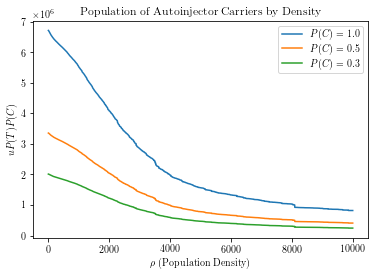

In [23]:
plotpopbydens(results_dens)

In [24]:
def getTable(ks, cs, A):
    results = {}
    for c in cs:
        results[c] = []
    for k in ks:
        val = 1 - (binom.cdf(i, np.floor(np.multiply(A, rho)), p))

IndentationError: expected an indented block (<ipython-input-24-cc924827babb>, line 6)